In [44]:
import dspy
import openai
import pandas as pd
import matplotlib.pyplot as plt
from deepeval import evaluate
from deepeval.metrics import FaithfulnessMetric, ToxicityMetric, ContextualRecallMetric, ContextualPrecisionMetric
from deepeval.test_case import LLMTestCase
import os

Asignamos la clave del API de _**OpenAI**_ que hayamos solicitado

In [4]:
#os.environ.get("OPENAI_API_KEY")

Configuramos nuestra instancia de OpenAI en DSPY. Se empleará el modelo GPT 3.5 (Turbo).

In [5]:
turbo = dspy.OpenAI(api_key= os.environ.get("OPENAI_API_KEY"), model='gpt-3.5-turbo')
dspy.settings.configure(lm=turbo)

Se declara **una especificación esquemática** sobre el tipo de prompt (input) y la manera de configurar la salida (resultado). Esto dará lugar a un prompting mucho más afinado y sofisticado, con una buena estructura y una mejor proyección.

In [6]:
class BasicQA(dspy.Signature):
    """Analizar sentimientos en unos mensajes"""
    mensaje = dspy.InputField()
    sentimiento = dspy.OutputField(desc="Retornar términos neutral, negative o positive")

Implementamos la técnica de la cadena de pensamiento, para inyectar un razonamiento que sea previo a la generación de respuestas (solo se hará un rellenado o culminación).

Se define, a posteriori, **un método que procesará un prompt basado en un supuesto mensaje y devolverá el sentimiento** que se le asocie por medio de la generación razonada con el LLM.

In [7]:
qa = dspy.ChainOfThought(BasicQA, n=1)

def obtenerAnalisisSentimiento(texto):
    response = qa(mensaje=texto)
    return response.completions.sentimiento[0]

C:\Users\am-gc\AppData\Roaming\Python\Python310\site-packages\pydantic\main.py:1291: RuntimeWarning: fields may not start with an underscore, ignoring "__doc__"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


Se carga un archivo CSV con **una serie de mensajes y una categoría de sentimiento asociada** (puede ser positivo, negativo o neutral)

In [8]:
dataset = pd.read_csv('test.csv')[['message','sentiment']]

Se seleccionan solo **once registros**

In [9]:
dataset = dataset.loc[:10]

Se creará una nueva columna en la que, en base al mensaje dado, se intente **deducir**, por medio del modelo de GPT dado, el sentimiento expresado

In [10]:
dataset['sentiment_llm'] = dataset.apply(lambda row: obtenerAnalisisSentimiento(row["message"]), axis=1)

In [56]:
dataset

,message,sentiment,sentiment_llm
0,Last session of the day http://twitpic.com/67ezh,neutral,Positive
1,Shanghai is also really exciting (precisely -...,positive,Positive
2,"Recession hit Veronique Branquinho, she has to...",negative,Negative
3,happy bday!,positive,positive
4,http://twitpic.com/4w75p - I like it!!,positive,Positive
5,that`s great!! weee!! visitors!,positive,Positive
6,I THINK EVERYONE HATES ME ON HERE lol,negative,Negative
7,"soooooo wish i could, but im in school and my...",negative,Negative
8,and within a short time of the last clue all ...,neutral,Positive
9,What did you get? My day is alright.. haven`...,neutral,Neutral


Mediante la librería _**DeepEval**_, se llevará a cabo una evaluación de las respuestas, en los respectivos casos de prueba (con la entrada, la salida actual, que es el resultado del procesamiento generativo, y la salida esperada conforme a lo que se asocia de antemano en el dataset).

Se tienen en cuenta 3 métricas:

- *Faithfulness*: Se evalúa si la salida actual se alinea, factualmente, con los contenidos del contexto de recuperación.

- *Precisión contextual*: Se evalúa si los nodos del contexto de recuperación que son relevantes para la actual entrada tienen mayor puntuación que aquellos que son menos relevantes.

- *Recuperación (recall) contextual*: Se evalúa la calidad del recuperador, a fin de ver en qué medida se alinea el contexto de recuperación con la salida esperada.

- *Toxicidad*: Se evalúa la proporción de opiniones tóxicas (odio, ataques personales, burlas, ruegos de censura e intimidación)

In [37]:
test_cases = []
for index, row in dataset.iterrows():
    test_case = LLMTestCase(
        input=row["message"],
        actual_output=row["sentiment_llm"],
        expected_output=row["sentiment"],
        retrieval_context=["""Los sentimientos pueden clasificarse en positivos, 
            negativos o neutrales. Los sentimientos positivos, como la felicidad, 
            gratitud, amor, esperanza y orgullo, generan bienestar, satisfacción 
            y alegría, y son fundamentales para una vida equilibrada. 
            Los sentimientos negativos, como la tristeza, ira, miedo, 
            ansiedad y envidia, provocan malestar, angustia y pueden 
            afectar negativamente nuestra salud mental si no se manejan adecuadamente. 
            Los sentimientos neutrales, como la indiferencia, curiosidad, sorpresa, 
            nostalgia y desinterés, no se categorizan claramente y su impacto emocional 
            depende del contexto en el que se experimentan. Entender y identificar estos 
            sentimientos es esencial para evaluar adecuadamente el estado emocional de 
            una persona y su bienestar general."""]
    )
    test_cases.append(test_case)
    
metric_faith = FaithfulnessMetric(
        threshold=0.77,
        model="gpt-3.5-turbo",
        include_reason=True
    )

metri_recall = ContextualRecallMetric(
        threshold=0.77,
        model="gpt-3.5-turbo",
        include_reason=True
    )

metric_prec = ContextualRecallMetric(
        threshold=0.77,
        model="gpt-3.5-turbo",
        include_reason=True
    )

metric_tox = ToxicityMetric(
        threshold=0.77,
        model="gpt-3.5-turbo",
        include_reason=True
    )

In [38]:
df = pd.DataFrame(columns=["Mensaje", "Faithfulness", "Recall", "Precision", "Toxicity"])

# Se definirá un 
for tc in test_cases:
    metric_faith.measure(tc)
    metri_recall.measure(tc)
    metric_prec.measure(tc)
    metric_tox.measure(tc)
    
    # Create a new row as a dictionary
    nueva_fila = {
        "Mensaje": tc.input, 
        "Faithfulness": metric_faith.score, 
        "Recall": metri_recall.score, 
        "Precision": metric_prec.score,
        "Toxicity": metric_tox.score
    }
    
    # Convert the dictionary to a DataFrame
    nueva_fila_df = pd.DataFrame([nueva_fila])
    
    # Concatenate the new DataFrame to the existing DataFrame
    df = pd.concat([df, nueva_fila_df], ignore_index=True)

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

In [39]:
df

,Mensaje,Faithfulness,Recall,Precision,Toxicity
0,Last session of the day http://twitpic.com/67ezh,1.0,1.0,1.000000,0.0
1,Shanghai is also really exciting (precisely -...,0.0,1.0,0.500000,0.0
2,"Recession hit Veronique Branquinho, she has to...",0.0,1.0,1.000000,0.0
3,happy bday!,0.0,1.0,0.250000,0.0
4,http://twitpic.com/4w75p - I like it!!,0.0,0.5,0.142857,0.0
5,that`s great!! weee!! visitors!,1.0,0.2,0.666667,0.0
6,I THINK EVERYONE HATES ME ON HERE lol,0.0,1.0,1.000000,0.0
7,"soooooo wish i could, but im in school and my...",0.0,1.0,1.000000,0.0
8,and within a short time of the last clue all ...,1.0,1.0,1.000000,0.0
9,What did you get? My day is alright.. haven`...,1.0,1.0,1.000000,0.0


In [50]:
df.describe()

,Faithfulness,Recall,Precision,Toxicity
count,11.000000,11.000000,11.000000,11.0
mean,0.363636,0.881818,0.778139,0.0
std,0.504525,0.271360,0.334194,0.0
min,0.000000,0.200000,0.142857,0.0
25%,0.000000,1.000000,0.583333,0.0
50%,0.000000,1.000000,1.000000,0.0
75%,1.000000,1.000000,1.000000,0.0
max,1.000000,1.000000,1.000000,0.0


In [51]:
df["Faithfulness"]

0     1.0
1     0.0
2     0.0
3     0.0
4     0.0
5     1.0
6     0.0
7     0.0
8     1.0
9     1.0
10    0.0
Name: Faithfulness, dtype: float64

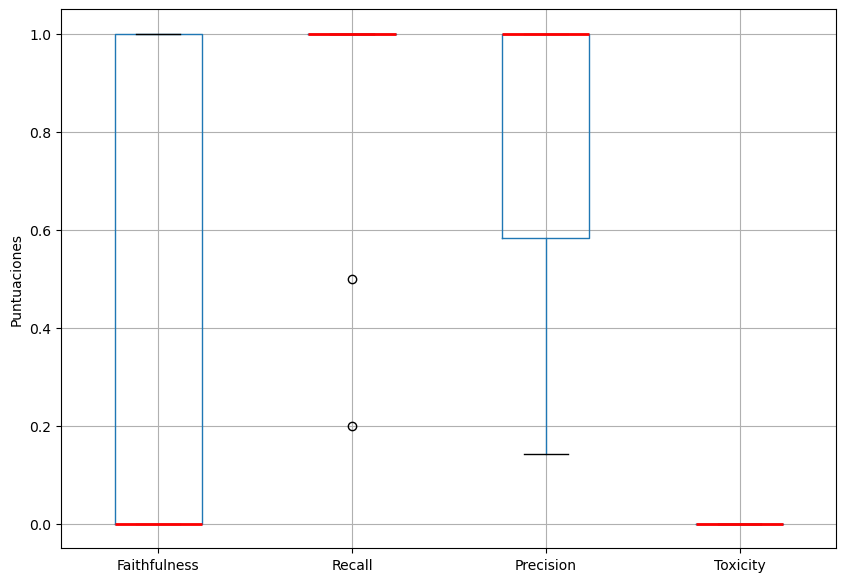

In [55]:
plt.figure(figsize=(10, 7))
boxplot = df.boxplot(column=['Faithfulness', 'Recall', 'Precision', 'Toxicity'], 
                     medianprops=dict(color="red", linewidth=2))
plt.ylabel('Puntuaciones')

plt.show()